# --------TAREA 1 CONFIGURACION DE ENTORNO Y PROCESO ETL INICIOS ------


**MAESTRIA EN CIBERSEGURIDAD**

**INTELIGENCIA DE NEGOCIOS**

**INTEGRANTES: JULIO AREVALO, EMILIO CORDOVA, NILSON ROMERO**

**2025**

## RESUMEN 
En este Notebook podrá encontrar el proceso completo de configuración de un entorno de análisis de datos y la ejecución de pipeline ETL. Se extraen datos de diferentes fuentes como PostgreSQL, CSV, JSON.
Se procede a cargar data Warehouse en PostgreSQL y se realiza una explotación y segmentación inicial de los datos utilizando librerías como Pandas en Python. 

# ----------IMPORTANCION DE LIBRERIAS CONEXION POSTGRESQL----------

Se inicia la actividad estableciendo la conexión a la base de datos de destino, esta DB funcionara como un **Data Warehouse**.
Utilizaremos como motor *DB* **PostgreSQL** esta base estará alojada en un contenedor **Docker**. Esto garantiza un entorno de desarrollo consistente, aislable y reproducible.
Se definen los parámetros de conexión y se creará el *motor* *(engine)* utilizando las librería *SQLalchemy*. El motor actuará como puente entre nuestra herramienta de análisis en Python y la base de datos.
En este proceso se ha implementado un bloque **try-except** para gestionar de forma precisa cualquier posible error durante el intento de conexión.

In [1]:
# ----- IMPORTACION DE LIBRERIAS -----
# Se importan las librerías necesarias para la manipulación de datos y para la conexión con la base de datos 
# qué contendrá la data.

import pandas as pd
from sqlalchemy import create_engine # crea la conexion a la base de datos
import os # proporciona funciones para interactuar con el sistema operativo (manejar rutas de archivos)
import json # para trabajar con datos en formato JSON
from dotenv import load_dotenv # para cargar variables de entorno desde un archivo .env
import matplotlib.pyplot as plt # Importacion de la libreria para la creación de un grafico comparativo de categorias por retraso
# ----- CONEXION A LA BASE DE DATOS POSTGRESQL EN DOCKER -----
# --- 2. CARGAR Y LEER VARIABLES DE ENTORNO ---
# La función load_dotenv() buscará y cargará las variables del archivo .env
load_dotenv('.venv/.env')
print("Variables de entorno cargadas.")

# Leemos cada variable del entorno usando os.getenv()
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

#-----Creación del motor de conexión SQLalchemy-----
#se utiliza un bloque try-except para el manejo de errores.
#Si la conexión falla el programa informará del error en lugar de tenerse abruptamente.
# --- 3. CONEXIÓN A LA BASE DE DATOS ---
print("Iniciando conexión a la base de datos...")
try:
    # La cadena de conexión ahora se construye con las variables cargadas, sin secretos en el código.
    engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

    # Verificamos la conexión para asegurar que todo funcionó
    with engine.connect() as connection:
        print("¡Conexión a PostgreSQL exitosa!")

except Exception as e:
    print(f"---> ERROR al conectar: {e}")   


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("Configuración de visualización de Pandas aplicada.")


Variables de entorno cargadas.
Iniciando conexión a la base de datos...
¡Conexión a PostgreSQL exitosa!
Configuración de visualización de Pandas aplicada.


En la salida nos indica que el proceso de conexion ha sido exitoso 


### CARGA MASIVA DE CSV A LA TABLA DE POSTGRESQL PROCESO ETL

En esta sección del código se podrá encontrar el núcleo del proceso **ETL** para inyectar la base de datos **postgreSQL**.
La consigna es consolidar múltiples archivos **CSV** relacionados en un único **data warehouse** y posteriormente se realizará el análisis de la información.

Se describe los pasos:

**Selección de la fuente EXTRACT:** Procedemos a definir una lista explícita de los archivos **CSV** que contienen las entidades del negocio las principales *(clientes, órdenes, productos)*

**Bucle de procesamiento:** se itegra sobre cada archivo de la lista para procesarlo de manera automatizada.

**Transformación ligera:** dentro del bucle se realiza una transformación básica para generar nombres de tabla limpios el lógicos a partir de los nombres de los archivos. ej. `olist_customers_dataset.csv` se convertirá en la tabla `customers`.

**Carga:** se utiliza la función **to_sql** de *Pandas* para cargar los datos de cada archivo en su tabla correspondiente dentro del progress SQL. Se ha configurado para reemplazar la tabla si ya existe.



In [2]:
# Definimos la ruta donde se encuentran los archivos CSV descargados de forma relativa

data_path = r'data/'

# SELECCIONAMOS LOS ARCHIVOS CSV
# Se crea una lista con los nombres de los archivos CSV que se van a cargar en la base de datos.
files_to_load_in_db = [
    'olist_customers_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_order_items_dataset.csv',
    'olist_products_dataset.csv',
    'olist_sellers_dataset.csv'
]

#----- Blucle para cargar los archivos CSV en la base de datos -----
# INICIAMOS EL PROCESO DE CARGA MASIVA DE LOS ARCHIVOS CSV A LA BASE DE DATOS

print("\nIniciando carga de datos a PostgreSQL...")
for file in files_to_load_in_db:
    # El nombre de la tabla será el del archivo sin la extensión y prefijos
    table_name = file.replace('olist_', '').replace('_dataset.csv', '')
    df = pd.read_csv(os.path.join(data_path, file))
    df.to_sql(table_name, engine, if_exists='replace', index=False)
    print(f"Tabla '{table_name}' cargada con {len(df)} filas.")
print("Carga a PostgreSQL completada.")


Iniciando carga de datos a PostgreSQL...
Tabla 'customers' cargada con 99441 filas.
Tabla 'orders' cargada con 99441 filas.
Tabla 'order_items' cargada con 112650 filas.
Tabla 'products' cargada con 32951 filas.
Tabla 'sellers' cargada con 3095 filas.
Carga a PostgreSQL completada.


### GENERACION DE LOS DATAFRAME PRINCIPALES
En este proceso procederemos a realizar la creacion de los dataframes con la libreria pandas.

Se procede con la **extracción de datos desde tres fuentes distintas**, generando un **DataFrame** para cada una de ellas.
Este proceso de simulación va a reflejar un escenario empresarial *real* dónde la información reside en un sistema.

**DataFrame creados:**
**`df_orders` (Desde PostgreSQL ):** Se consultará la tabla de nuestro **DataWarehouse** esta presenta la fuente de datos principales ya consolidada y estructura.
**`df_order_reviews` (Desde CSV ):** Se leerá un archivo **CSV** externo, esto simula la ingesta de datos provenientes de un reporte externo o un sistema *Legacy*.
**`df_json` (Desde JSON):** Se simula una fuente `JSON` el proceso consistirá en convertir primero un archivo `csv` de referencia a un archivo `JSON` Y luego leerlo.


In [3]:
#----- Creacion del dataframe 1 desde PostGreSQL-----

print("1. Creando dataframe desde PostgreSQL tabla 'orders'")
query_orders = "SELECT * FROM orders;"
df_orders = pd.read_sql(query_orders, engine)

# ----- Creacion del dataframe 2 desde CSV -----

print("2. CREACION DE DATAFRAME DESDE CSV ('ORDER_REVIWS') ")
df_order_reviews = pd.read_csv(os.path.join(data_path, 'olist_order_reviews_dataset.csv'))

#----- creacion del dataframe 3 desde JSON -----

print("3. CREACION DE DATAFRAME DESDE JSON ('product_category_translation') ")

# convertir el csv a un archivo JSON PARA SIMULAR LA FUENTE
df_temp_json = pd.read_csv(os.path.join(data_path, 'product_category_name_translation.csv'))
json_path = os.path.join(data_path, 'categories.json')
df_temp_json.to_json(json_path, orient='records', lines=True)

# leer el archivo JSON
df_json = pd.read_json(json_path, lines=True)

print("LOS DATAFRAME PRINCIPALES HAN SIDO CREADOS EXITOSAMENTE")


1. Creando dataframe desde PostgreSQL tabla 'orders'
2. CREACION DE DATAFRAME DESDE CSV ('ORDER_REVIWS') 
3. CREACION DE DATAFRAME DESDE JSON ('product_category_translation') 
LOS DATAFRAME PRINCIPALES HAN SIDO CREADOS EXITOSAMENTE


# EXPLORACION Y FILTROS DEL DATAFRAME  DE POSTGRESQL DF_POSTGRES

Una vez que se ha procedido a cargar los **DataFrame** el siguiente paso es realizar el ** análisis exploratorio de datos EDA** este paso es fundamental para comprender la naturaleza de nuestra información antes de realizar otro tipo de análisis que sean más complejos.

Se inicia con él **DataFrame** `df_orders`, Que contiene la información de las órdenes de compra en nuestra base de datos **PostgreSQL**

**Se ha dividido el análisis en dos partes:**

**Exploración inicial:** Se utilizarán los métodos `.info()` y `.head()` de `Pandas` para responder 

**Filtrado y Segmentación:** Se aplicarán tres filtros específicos para segmentar los datos y responder a preguntas de negocio iniciales.

In [4]:
# Exploracion de los dataframes creados
# Exploramos los dataframes creados para entender su estructura y contenido.

print("exploracion del postgreSQL df_postgres (orders)")
print(df_orders.info())
print("\nPrimeras cinco filas:")
display(df_orders.head())


exploracion del postgreSQL df_postgres (orders)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None

Primeras cinco filas:


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
# FILTRO PEDIDOS ENTREGADOS
entregados = df_orders[df_orders['order_status'] == 'delivered']
print(f"HAY {len(entregados)} PEDIDOS ENTREGADOS")

# PEDIDOS REALIZADOS EN EL 2017
pedidos_2017 = df_orders[pd.to_datetime(df_orders['order_purchase_timestamp']).dt.year == 2017]
print(f"hay {len(pedidos_2017)} pedidos realizados en el 2017")
pedidos_2017


HAY 96478 PEDIDOS ENTREGADOS
hay 45101 pedidos realizados en el 2017


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,None,None,2017-05-09 00:00:00
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00
...,...,...,...,...,...,...,...,...
99433,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07 00:00:00
99434,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17 00:00:00
99435,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22 00:00:00
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00


In [6]:
# ----- PEDIDOS CANCELADOS O NO DISPONIBLES -----
cancelados = df_orders[df_orders['order_status'].isin(['canceled', 'unavailable'])]
print(f"HAY {len(cancelados)} PEDIDOS CANCELADOS O NO DISPONIBLES")
cancelados

HAY 1234 PEDIDOS CANCELADOS O NO DISPONIBLES


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,None,None,2017-12-05 00:00:00
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,None,None,2018-08-14 00:00:00
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,None,None,2018-02-16 00:00:00
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,None,2018-02-22 00:00:00
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,None,None,2017-09-05 00:00:00
...,...,...,...,...,...,...,...,...
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,None,None,2018-02-06 00:00:00
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,None,None,None,2018-10-01 00:00:00
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,None,None,None,2018-09-27 00:00:00
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,None,None,2017-09-15 00:00:00


### EXPLORACION Y FILTROS DATAFRAME CSV

Esta vez enfocándonos en el DataFrame `df_order_reviews`, que fue cargado desde nuestra fuente CSV obligatoria.

Estos datos son **crítico para entender la satisfacción del cliente**, ya que contiene las puntuaciones y comentarios que los usuarios han dejado después de una compra.



**El proceso es el sigguiente:**

**Exploración de la Estructura de Datos** 

**Interpretación de Hallazgos Preliminares**

Se analizará la salida de la exploración para identificar puntos clave, como la cantidad de comentarios escritos versus reseñas sin texto, y la necesidad de convertir tipos de datos para análisis futuros.

In [7]:
print("----- exploracion de df_csv (reviews) -----")
print(df_order_reviews.info())
print("\nPrimeras cinco filas:")
display(df_order_reviews.head())

----- exploracion de df_csv (reviews) -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None

Primeras cinco filas:


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parab...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [8]:
## ----- reseñas con una puntuación de cinco estrellas -----
resenias_5_estrellas = df_order_reviews[df_order_reviews['review_score'] == 5]
print(f"HAY {len(resenias_5_estrellas)} RESEÑAS CON 5 ESTRELLAS")
resenias_5_estrellas

HAY 57328 RESEÑAS CON 5 ESTRELLAS


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parab...,2018-03-01 00:00:00,2018-03-02 10:26:53
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
...,...,...,...,...,...,...,...
99217,c6b270c61f67c9f7cb07d84ea8aeaf8b,48f7ee67313eda32bfcf5b9c1dd9522d,5,NaN,NaN,2017-12-13 00:00:00,2017-12-14 11:09:36
99218,af2dc0519de6e0720ef0c74292fb4114,d699c734a0b1c8111f2272a3f36d398c,5,NaN,NaN,2018-04-27 00:00:00,2018-04-30 01:18:57
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42


In [9]:
## ----- RESEÑAS CON COMENTARIOS -----
resenias_con_comentarios = df_order_reviews[df_order_reviews['review_comment_message'].notnull() & (df_order_reviews['review_comment_message'].str.strip() != '')]
print(f"HAY {len(resenias_con_comentarios)} RESEÑAS CON COMENTARIOS")
resenias_con_comentarios

HAY 40950 RESEÑAS CON COMENTARIOS


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parab...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfec...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes do prazo.",2018-05-23 00:00:00,2018-05-24 03:00:01
...,...,...,...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,NaN,para este produto recebi de acordo com a compra realizada!,2017-11-29 00:00:00,2017-11-30 15:52:51
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,NaN,Entregou dentro do prazo. O produto chegou em condições perfeitas. Estou mui...,2018-02-07 00:00:00,2018-02-19 19:47:23
99215,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,NaN,"O produto não foi enviado com NF, não existe venda sem NF, com certeza fico ...",2018-05-19 00:00:00,2018-05-20 21:51:06
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super recomendo essa loja!",2018-03-22 00:00:00,2018-03-23 09:10:43


In [10]:
## RESEÑAS CON LA MINIMAPUNTUACIÓN 1 ESTRELLA
resenias_1_estrella = df_order_reviews[df_order_reviews['review_score'] == 1]
print(f"HAY {len(resenias_1_estrella)} RESEÑAS CON 1 ESTRELLA")
resenias_1_estrella

HAY 11424 RESEÑAS CON 1 ESTRELLA


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37
29,2c5e27fc178bde7ac173c9c62c31b070,0ce9a24111d850192a933fcaab6fbad3,1,NaN,Não gostei ! Comprei gato por lebre,2017-12-13 00:00:00,2017-12-16 07:14:07
32,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1,NaN,"Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que...",2018-04-08 00:00:00,2018-04-09 12:22:39
39,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,NaN,Nada de chegar o meu pedido.,2017-04-21 00:00:00,2017-04-23 05:37:03
...,...,...,...,...,...,...,...
99144,e5a991ae8286f513e512f0f9fd188f9b,fadb25c91522130892be8a5ddb3e139f,1,NaN,NaN,2018-04-14 00:00:00,2018-04-16 18:37:40
99155,2fc8295a24978092328d3a329d22940e,e809c167a9cfd31aee1293abe8995065,1,NaN,Eu recebi o seguinte email e preciso saber como recuperar o dinheiro ou comp...,2018-02-09 00:00:00,2018-02-13 13:03:24
99169,3450ec3bbabeb09a08b00fc72da87a30,c46f950813dd2dd9bab4188dceb83175,1,NaN,Boa tarde. \r\nNão recebo todos os produtos falta o bebe conforto e a base d...,2017-12-08 00:00:00,2017-12-08 19:07:00
99184,6cf47345d15e054dd6df872e929bdb27,54e6829fe81bc86cf88b12e6d07ea298,1,NaN,NaN,2017-06-08 00:00:00,2017-06-08 22:52:39


### ANALISIS DE JSON 
Finalmente, se realiza el Análisis Exploratorio de Datos (EDA) para el DataFrame `df_json`. Este conjunto de datos fue cargado desde la **fuente JSON simulada** y contiene la traducción de los nombres de las categorías de productos del portugués al inglés.


In [11]:
# EXPLORACIÓN DE DF_JSON 
print("----- Exploración de df_json (categories_translation) -----")
print(df_json.info())
print("\nPrimeras cinco filas:")
display(df_json.head())



----- Exploración de df_json (categories_translation) -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
None

Primeras cinco filas:


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [12]:
# ----- CATEGORIAS RELACIONADAS CON LA CAMA Y EL BAÑO -----
cama_bano = df_json[df_json['product_category_name_english'] == 'bed_bath_table']
print(f"HAY {len(cama_bano)} CATEGORIAS RELACIONADAS CON LA CAMA Y EL BAÑO")
cama_bano

HAY 1 CATEGORIAS RELACIONADAS CON LA CAMA Y EL BAÑO


,product_category_name,product_category_name_english
3,cama_mesa_banho,bed_bath_table


In [13]:
# CATEGORIAS RELACIONADAS CON LA PALABRA COMPUTADORA EN PORTUGUES
computadoras_pt = df_json[df_json['product_category_name'].str.contains('informatica', na=False)]
print(f"HAY {len(computadoras_pt)} CATEGORIAS RELACIONADAS CON LA PALABRA COMPUTADORA EN PORTUGUES")
computadoras_pt



HAY 1 CATEGORIAS RELACIONADAS CON LA PALABRA COMPUTADORA EN PORTUGUES


,product_category_name,product_category_name_english
1,informatica_acessorios,computers_accessories


In [14]:
# CATEGORIA REALCIONADA CON EL DEPORTE Y OCIO
deporte_ocio = df_json[df_json['product_category_name_english'] == 'sports_leisure']
print(f"HAY {len(deporte_ocio)} CATEGORIAS RELACIONADAS CON EL DEPORTE Y OCIO")
deporte_ocio

HAY 1 CATEGORIAS RELACIONADAS CON EL DEPORTE Y OCIO


,product_category_name,product_category_name_english
5,esporte_lazer,sports_leisure


# CAMBIOS SOLICITADOS EN CLASES
En cumplimiento con las mejores practicas de seguridad y desarrollo, hemos procedido a realizar los cambios solicitados, se procede a gestionar a traves de **variables de entorno** los datos de conexion de nuestra base de datos para este efecto en nuestra **tarea 1** realizamos los siguientes cambios.

1  Instalamos la libreria **pyrhon-dotenv**

2  Creamos el archivo .env e incluimos los datos de conexion de nuestra DB

3  En el archivo .gitignore añadimos la linea debidamente comentada que excluye la carga del archivo que contiene las credenciales

4  En la celda de codigo de conexion a la base de datos cambiamos el esquema y utilizamos la carga y lectura de las variables de entorno

5  Se modifica el motor de conexion para que utilice las variables cargadas.

# TAREA 2 TRANSFORMACIÓN Y LIMPIEZA DE DATOS 
------

**MAESTRÍA EN CIBERSEGURIDAD**

**INTELIGENCIA DE NEGOCIOS**

**INTEGRANTES: JULIO AREVALO, EMILIO CORDOVA, NILSON ROMERO**


## RESUMEN

En esta seccion del NoteBook se documenta el processo completo que hemos de seguir para la **FASE DE TRANFORMACION** de un pipeline **ETL** Utilizando los datos extraidos de la **TAREA 1**, se procedera a explicar diferentes tecnicas de limpieza, normalizar y enriquecer la data para asegurar la calidad y preparar para el respectivo análisis. 
Cada integrante del grupo se enfocará en un DataFrame específico, utilizando un entorno de trabajo colaborativo con Git.

## Sección julio/feature-limpieza-orders

** LIMPIEZA Y ENREQUECIMIENTO DE `df_orders`

En esta sección no enfocaremos en el DataFrame `df_orders`, este DataFrame contiene la información centrak de las transacciones.
La tarea a ejecutar sera limpiar los datos, manejar valores nulos y crear nuevas variables que permitan aportar valor al analisis, siguiendo las sugerencias del docente y los requisitos del componente practico 2.


In [15]:
# -----ANÁLISIS EXPLORATORIO PROFUNDO DEL DATAFRAME DF_ORDERS -----

#Diagnoosticamos el estado de los datos en el dataframe df_orders
print ("Distribución de estados de las órdenes:")
# values_counts() cuenta la frecuencia de cada estado
print(df_orders['order_status'].value_counts())

print("\n Conteo de valores nulos inicial por columnas:")
#.isna() nos da un dataframe de los datos faltantes.
print(df_orders.isna().sum())
"""
# --- ANÁLISIS EXPLORATORIO PROFUNDO DE DF_ORDERS ---

print("a. Distribución de estados de las órdenes:")
display(df_orders['order_status'].value_counts())

print("\nb. Conteo de valores nulos inicial por columna:")
display(df_orders.isna().sum())
"""
# --- ¡AÑADE ESTA LÍNEA AQUÍ! ---
print("\nc. Nombres exactos de las columnas:")
print(df_orders.columns.tolist())

Distribución de estados de las órdenes:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

 Conteo de valores nulos inicial por columnas:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

c. Nombres exactos de las columnas:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']


### Creación de una función de limpieza centralizada

-> Punto D: Se encapsulan todos los pasos de limpieza y transformación en una unica función reutilizable llamada `limpiar_df_orders`
    esta accion nos va a permitir la organización y mantenibilidad del código desarrollado.
-> Punto E: Evaluación de columnas, quitar nulos de columnas relacionales orden sin customer_id.
-> Convertir todas las columnas de fecha a formato datetime.
-> Punto F y G: Realizar transformaciones y expandir DataFrame.
-> Función `lambda` 0 o 1 indicara si la compra se realizo el fin de semana.


In [16]:
#------ FUNCIÓN DE LIMPIEZA Y TRANSFORMACIÓN PARA ÓRDENES -----

def limpiar_df_orders(df_crudo):
    """
    Descripcion del proceso: Toma el DataFrame de órdenes crudo y aplica un pipeline completo de limpieza
    manejo de nulos y enrequecimiento de datos.

    """
    print("Iniciando limpieza y transformación de df_orders...")

    # creacion de una copia para no modificar los datos originales

    df_limpio = df_crudo.copy()

    # Punto E: Evaluar columnas y quitar nulos de columnas relacionales
    # Una orden sin customer_id no tiene valor realacional, por lo que se elimina la fila.
    filas_antes = len(df_limpio)
    df_limpio.dropna(subset=['customer_id'], inplace=True)
    filas_despues = len(df_limpio)
    print(f"---> Se eliminaron {filas_antes - filas_despues} filas con 'customer_id' nulo. ")

    # Convertimos todas las columnas de fechas a formato datetime.
    # error='coerce' convertirá cualquier valor no convertible a NaT (Not a Time)
    columnas_fecha = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                      'order_delivered_customer_date', 'order_estimated_delivery_date']
    for col in columnas_fecha:
        df_limpio[col] = pd.to_datetime(df_limpio[col], errors='coerce')
        
    print("---> Columnas de FECHAS convertidas a datetime.")

        # --- Realizar transformaciones y expandir el DAtaFrame ---
        # Se crean nuevas columnas para enriquecer el análisis.

        #1. Calculamos el tiempo real de entrega en días
    df_limpio['tiempo_entrega_dias'] = (df_limpio['order_delivered_customer_date'] - 
                                            df_limpio['order_purchase_timestamp']).dt.days
        
        #2. Dias de retraso en la entrega Valor negativo significa que llego antes de lo estimado
    df_limpio['dias_retraso'] = (df_limpio['order_delivered_customer_date'] -
                                     df_limpio['order_estimated_delivery_date']).dt.days
        
        #3. Usando la función lambda para identificar si la compra se realizó en fin de semana creamos una columna 
        # booleana (1 o 0)
    df_limpio['compra_finde'] = df_limpio['order_purchase_timestamp'].apply(lambda fecha: 1 if pd.notna(fecha) and fecha.dayofweek >= 5 else 0)
    print("----- nuevas columnas creadas: 'tiempo_entrega_dias', 'dias_retraso', 'compra_finde' -----")

    print("Limpieza y transformación de df_orders completada.")
    return df_limpio

#Ejecutamos la función para obtener nuestro DataFrame limpio y enriquecido
df_orders_limpio = limpiar_df_orders(df_orders)

# Vefificamos el resultado mostrando las nuevas columnas 
display(df_orders_limpio[['order_id', 'tiempo_entrega_dias', 'dias_retraso', 'compra_finde']].head())




Iniciando limpieza y transformación de df_orders...
---> Se eliminaron 0 filas con 'customer_id' nulo. 
---> Columnas de FECHAS convertidas a datetime.
----- nuevas columnas creadas: 'tiempo_entrega_dias', 'dias_retraso', 'compra_finde' -----
Limpieza y transformación de df_orders completada.


,order_id,tiempo_entrega_dias,dias_retraso,compra_finde
0,e481f51cbdc54678b7cc49136f2d6af7,8.00,-8.00,0
1,53cdb2fc8bc7dce0b6741e2150273451,13.00,-6.00,0
2,47770eb9100c2d0c44946d9cf07ec65d,9.00,-18.00,0
3,949d5b44dbf5de918fe9c16f97b45f8a,13.00,-13.00,1
4,ad21c59c0840e6cb83a9ceb5573f8159,2.00,-10.00,0


### Integración de grafico de barras para comparar categorias
se agrega un grafico de barras que permite realizar una presentación haciendo un analisis de la satisfacción en base al retraso
y un conteo general por cada categoria.

### procedimiento
instalamos `matplotlib`
importamos la libreria `matplotlib.pylot`

-> creación de la categoria de retraso (`categoria_retraso`)

-> Conteo de valores 

-> Creación del grafico

--- Mejorando la Presentación: Visualización Gráfica del Análisis de Órdenes ---

Análisis de Retrasos en las Entregas:

Conteo exacto por categoría:


,count
estado_retraso,
Entrega Anticipada,88649
Con Retraso,6535
No Entregado,2965
A Tiempo,1292


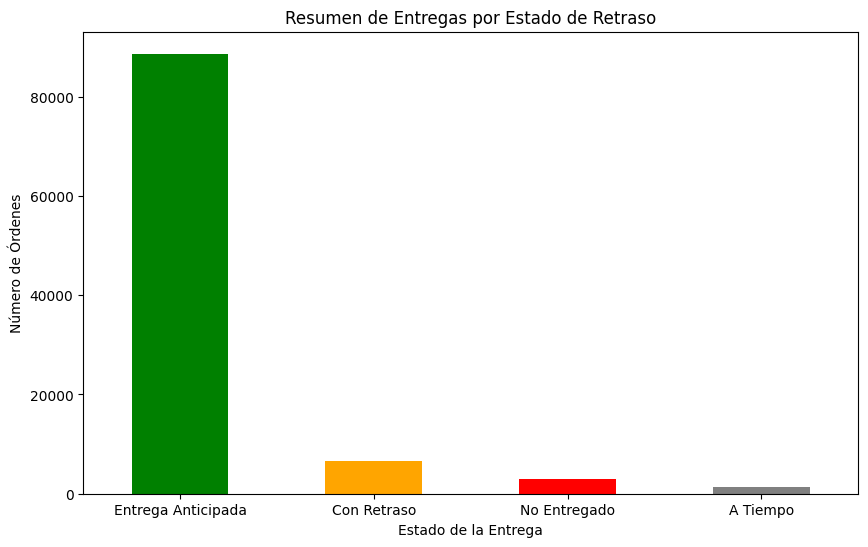

In [17]:

# --- VISUALIZACIÓN GRÁFICA DEL ANÁLISIS ---


print("--- Mejorando la Presentación: Visualización Gráfica del Análisis de Órdenes ---")


# --- 1. Gráfico 1: Resumen de Satisfacción (Retrasos) ---

print("\nAnálisis de Retrasos en las Entregas:")

# Creamos una nueva categoría para el análisis
def categoria_retraso(dias):
    if pd.isna(dias):
        return 'No Entregado'
    if dias > 0:
        return 'Con Retraso'
    elif dias == 0:
        return 'A Tiempo'
    else:
        return 'Entrega Anticipada'

df_orders_limpio['estado_retraso'] = df_orders_limpio['dias_retraso'].apply(categoria_retraso)

# Contamos los valores y los preparamos para el gráfico
retraso_counts = df_orders_limpio['estado_retraso'].value_counts()

# Mostrar la tabla de conteo para tener los números exactos
print("\nConteo exacto por categoría:")
display(retraso_counts.to_frame())


# Estructura del grafico de barras para el análisis por categoria
retraso_counts.plot(
    kind='bar',
    title='Resumen de Entregas por Estado de Retraso',
    figsize=(10, 6),
    xlabel='Estado de la Entrega',
    ylabel='Número de Órdenes',
    rot=0, # Rotación de las etiquetas del eje X
    color=['green', 'orange', 'red', 'grey'] # Colores personalizados
)
# Mostramos el gráfico
plt.show()



## Sección nilson/feature-limpieza-reviews


El siguiente dataframe analizado contine información sobre los pedidos realizados en la plataforma de comercio electrónico Olist en Brazil. Con el analisis y limpieza de estos datos buscamos entender la experiencia del cliente, el comportamiento de las compras y la evaluación de los productos.



Iniciamos con un análisis exploratorio del dataframe df_order_reviews mostrando los datos de interes que para nuestro caso son:

    - review_score
    - review_comment_tittle
    - review_comment_message

In [18]:
# Mostramos la tabla con la data de interes
df_order_reviews[['review_score', 'review_comment_title', 'review_comment_message' ]]

,review_score,review_comment_title,review_comment_message
0,4,NaN,NaN
1,5,NaN,NaN
2,5,NaN,NaN
3,5,NaN,Recebi bem antes do prazo estipulado.
4,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parab...
...,...,...,...
99219,5,NaN,NaN
99220,5,NaN,NaN
99221,5,NaN,"Excelente mochila, entrega super rápida. Super recomendo essa loja!"
99222,4,NaN,NaN


In [19]:
# Verificar los tipos de datos del Dataframe
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


Analizamos la frecuencia de las puntuaciones de las reseñas, para determinar que puntuaciones son las mas frecuentes entre los clientes

In [20]:
# Se imprime la frecuencia de las puntuaciones de las reseñas
print(df_order_reviews['review_score'].value_counts())

review_score
5    57328
4    19142
1    11424
3     8179
2     3151
Name: count, dtype: int64


El resultado obtenido es bastante positivo, se visualiza que las calificaciones más frecuentes entre los clientes es 4 y 5, calificaciones que muestran que el 77,1% de los clientes tienen comentarios positivos

 Para realizar el proceso de limpieza nos interesa conocer los valores nulos presentes en cada columna, lo cual se realiza a continuación

In [21]:
print("\nConteo de valores nulos en cada columna:") #mostramos un mensaje en pantalla con el mensaje dentro del print
print(df_order_reviews[['review_score', 'review_comment_title', 'review_comment_message']].isna().sum()) # mostramos en pantalla la cantidad de valores nulos presentes en cada columna


Conteo de valores nulos en cada columna:
review_score                  0
review_comment_title      87656
review_comment_message    58247
dtype: int64


Sabiendo que existen valores nulos en las columnas, se empieza a realizar el proceso de limpieza de los datos

In [22]:
# Definir la función de limpieza
def limpiar_df_reviews(df_order_reviews):
    # 1. Manejo de Nulos: Rellenar los valores nulos con "Sin Comentario"
    df_order_reviews['review_comment_title'] = df_order_reviews['review_comment_title'].fillna('Sin Comentario')
    df_order_reviews['review_comment_message'] = df_order_reviews['review_comment_message'].fillna('Sin Comentario')

    # 2. Convertir review_creation_date a tipo datetime
    df_order_reviews['review_creation_date'] = pd.to_datetime(df_order_reviews['review_creation_date'], errors='coerce')

    # Retornar el DataFrame limpio
    return df_order_reviews

# Aplicar la función a df_order_reviews
df_order_reviews_cleaned = limpiar_df_reviews(df_order_reviews)

Una vez reemplazo el valor null por "sin comentario", los imprimimos en pantalla para evidenciar si se realizó le cambio

In [23]:
# Verificar los cambios
print(df_order_reviews_cleaned.head(5))

# Verificar que no hay valores nulos en las columnas de comentarios
print("\nConteo de valores nulos después de limpieza:")
print(df_order_reviews_cleaned[['review_comment_title', 'review_comment_message']].isna().sum())

# Verificar el tipo de datos de la columna review_creation_date
print("\nTipo de dato de review_creation_date:")
print(df_order_reviews_cleaned['review_creation_date'].dtype)

                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4       Sin Comentario   
1             5       Sin Comentario   
2             5       Sin Comentario   
3             5       Sin Comentario   
4             5       Sin Comentario   

                                                            review_comment_message  \
0                                                                   Sin Comentario   
1                                                                   Sin Comentario   
2                                                             

Creamos una función que use lambda para agregar una columna categoria_satisfacción con los siguientes parámetros

    - Si review_score es 4 o 5 --> "Satisfecho"
    - Si review_score es 3 --> "Neutral"
    - Si review_score es 1 o 2 --> "Insatisfecho"

In [24]:
# Función para agregar la columna 'categoria_satisfaccion' según 'review_score'
def agregar_categoria_satisfaccion(df_order_reviews):
    df_order_reviews['categoria_satisfaccion'] = df_order_reviews['review_score'].apply(
        lambda x: 'Satisfecho' if x >= 4 else ('Neutral' if x == 3 else 'Insatisfecho')
    )
    return df_order_reviews

# Aplicar la función a df_order_reviews
df_order_reviews_cleaned = agregar_categoria_satisfaccion(df_order_reviews_cleaned)

# Verificar los cambios
print(df_order_reviews_cleaned[['review_score', 'categoria_satisfaccion']].head())


   review_score categoria_satisfaccion
0             4             Satisfecho
1             5             Satisfecho
2             5             Satisfecho
3             5             Satisfecho
4             5             Satisfecho


Mostramos todo el dataset con los cambio realizados para visualizar los cambios desarrollados por las funciones.

In [25]:
df_order_reviews_cleaned.head(20)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,categoria_satisfaccion
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,Sin Comentario,Sin Comentario,2018-01-18,2018-01-18 21:46:59,Satisfecho
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,Sin Comentario,Sin Comentario,2018-03-10,2018-03-11 03:05:13,Satisfecho
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,Sin Comentario,Sin Comentario,2018-02-17,2018-02-18 14:36:24,Satisfecho
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Sin Comentario,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,Satisfecho
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Sin Comentario,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parab...,2018-03-01,2018-03-02 10:26:53,Satisfecho
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,Sin Comentario,Sin Comentario,2018-04-13,2018-04-16 00:39:37,Insatisfecho
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,Sin Comentario,Sin Comentario,2017-07-16,2017-07-18 19:30:34,Satisfecho
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,Sin Comentario,Sin Comentario,2018-08-14,2018-08-14 21:36:06,Satisfecho
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,Sin Comentario,Sin Comentario,2017-05-17,2017-05-18 12:05:37,Satisfecho
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfec...,2018-05-22,2018-05-23 16:45:47,Satisfecho


## Sección emilio/feature-limpieza-json-indices

Esta sección finaliza el proceso de transformación. Primero, se limpia el DataFrame de soporte `df_json` que contiene la traducción de categorías. Segundo, y como paso final de la preparación, se generan índices numéricos secuenciales para los DataFrames principales, asegurando un identificador único para cada registro.

In [26]:
# --- 8. FUNCIÓN DE LIMPIEZA PARA CATEGORÍAS ---
def limpiar_df_categorias(df):
    """
    Limpia el DataFrame de traducción de categorías.
    """
    df_limpio = df.copy()

    # a. Eliminar filas si alguna de las columnas es nula
    df_limpio.dropna(inplace=True)

    # b. Estandarizar el texto a minúsculas para consistencia
    df_limpio['product_category_name'] = df_limpio['product_category_name'].str.lower()
    df_limpio['product_category_name_english'] = df_limpio['product_category_name_english'].str.lower()

    return df_limpio

# Ejecutar la función
df_json_limpio = limpiar_df_categorias(df_json)

print("\nLimpieza de df_json completada. Muestra del DataFrame limpio:")
display(df_json_limpio.head())



Limpieza de df_json completada. Muestra del DataFrame limpio:


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


Python (Generación de Índices)

In [28]:
# --- 9. GENERACIÓN DE ÍNDICES NUMÉRICOS SECUENCIALES ---
# Se toma el DataFrame limpio de órdenes y se le añade un ID secuencial.
df_orders_final = df_orders_limpio.reset_index()
df_orders_final.rename(columns={'index': 'orden_id_secuencial'}, inplace=True)

# Se hace lo mismo para el DataFrame de reseñas.
df_reviews_final = df_order_reviews_cleaned.reset_index()
df_reviews_final.rename(columns={'index': 'review_id_secuencial'}, inplace=True)

print("\nÍndices numéricos generados para los DataFrames principales.")
display(df_orders_final[['orden_id_secuencial', 'order_id']].head())
print(df_reviews_final.columns)

print("\nMuestra del DataFrame de reseñas con nuevo índice:")
display(df_reviews_final[['review_id_secuencial', 'review_id', 'review_score']].head())



Índices numéricos generados para los DataFrames principales.


,orden_id_secuencial,order_id
0,0,e481f51cbdc54678b7cc49136f2d6af7
1,1,53cdb2fc8bc7dce0b6741e2150273451
2,2,47770eb9100c2d0c44946d9cf07ec65d
3,3,949d5b44dbf5de918fe9c16f97b45f8a
4,4,ad21c59c0840e6cb83a9ceb5573f8159


Index(['review_id_secuencial', 'review_id', 'order_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'categoria_satisfaccion'],
      dtype='object')

Muestra del DataFrame de reseñas con nuevo índice:


,review_id_secuencial,review_id,review_score
0,0,7bc2406110b926393aa56f80a40eba40,4
1,1,80e641a11e56f04c1ad469d5645fdfde,5
2,2,228ce5500dc1d8e020d8d1322874b6f0,5
3,3,e64fb393e7b32834bb789ff8bb30750e,5
4,4,f7c4243c7fe1938f181bec41a392bdeb,5


## Conclusión de la Práctica 2

En esta práctica, el equipo ha ejecutado exitosamente la fase de **Transformación** de un proceso ETL. Se aplicaron técnicas de limpieza, manejo de valores nulos, conversión de tipos de datos y enriquecimiento (feature engineering) a tres fuentes de datos distintas.

El trabajo se organizó de forma colaborativa utilizando Git y GitHub, donde cada miembro del equipo se responsabilizó de un DataFrame, culminando en la integración de un notebook cohesivo y bien documentado. Los datos ahora están limpios, consistentes y enriquecidos, listos para ser cargados en un sistema de destino para su posterior análisis y explotación en sistemas de BI.